# Marked exercises after Lecture 10 on Diffusion models

This notebook contains the marked exercises with instructions and explanations.

Work through the cells below in sequential order, executing each cell as you progress. Throughout the exercise, you will encounter instructions marked with the words **YOUR CODE HERE** followed by **raise NotImplementedError()**. You will have to substitute  *raise NotImplementedError()* with your own code.
Follow the instructions and write the code to complete the tasks.

**IMPORTANT NOTE**: You are **NOT ALLOWED** to change the code that we provide. All of the definitions of functions and all the hyperparameters should be kept as they are. You are NOT allowed to create new functions and you are ONLY allowed to write your code wherever you see raise NotImplementedError.

Along the way, you may also find questions. Try to reflect on the questions before/after running the code.

This notebook was developed at the [Idiap Research Institute](https://www.idiap.ch) by [Alina Elena Baia](mailto:alina.baia.idiap.ch>), [Darya Baranouskaya](mailto:darya.baranouskaya.idiap.ch) and [Olena Hrynenko](mailto:olena.hrynenko.idiap.ch) (equal contribution). Any reproduction or distribution of this document, in whole or in part, is prohibited unless permission is granted by the authors.

<!--
SPDX-FileCopyrightText: Copyright (c) 2024 Idiap Research Institute <contact@idiap.ch>
SPDX-FileContributor: Alina Elena Baia <alina.baia.idiap.ch>
SPDX-FileContributor: Darya Baranouskaya <darya.baranouskaya.idiap.ch>
SPDX-FileContributor: Olena Hrynenko <olena.hrynenko.idiap.ch>
-->

Note: This notebook serves as the main file for the marked exercise and contains  the  code for initialising the models, initialising the dataset, setting the hyperparameters for training, and training the model. No code implementation is required in this notebook file. You are allowed to change hyperparameters.

Make sure to upload the required source files. You will be asked to modified these files in order to complete the tasks.

You are asked to complete the following tasks related to completing the implementation of a DDPM diffusion model and its training function according to the following paper: Ho, J., Jain, A. and Abbeel, P., 2020. Denoising diffusion probabilistic models. Advances in neural information processing systems, 33, pp.6840-6851, https://proceedings.neurips.cc/paper/2020/hash/4c5bcfec8584af0d967f1ab10179ca4b-Abstract.html.

You will:
- 2.10.5 [5 points]  Implement the forward diffusion process (one step and a cycle for noising the image).
- 2.10.6 [5 points]  Implement training.
- 2.10.7 [15 points] Implement ReverseDiffusionProcess.
- 2.10.8 [4 points] Train the model and sample images.



- **IMPORTANT REMINDER**: Make sure to also complete the following tasks (2.10.9 and 2.10.10), which do not require code implementation. Follow the instructions provided in the Marked_exercises_submission2_lecture10.pdf file.



The notebook is developed with the help of the resources referenced at the bottom of the notebook. The images for theory explanations are taken from the references resources.

References:\
[0] [Ho, J., Jain, A. and Abbeel, P., 2020. Denoising diffusion probabilistic models. Advances in neural information processing systems, 33, pp.6840-6851.](https://proceedings.neurips.cc/paper/2020/hash/4c5bcfec8584af0d967f1ab10179ca4b-Abstract.html) \
[1] https://lilianweng.github.io/posts/2021-07-11-diffusion-models/ \
[2] https://medium.com/better-programming/diffusion-models-ddpms-ddims-and-classifier-free-guidance-e07b297b2869 \
[3] https://github.com/FilippoMB/Diffusion_models_tutorial/tree/main \
[4] https://theaisummer.com/diffusion-models/


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import os

#### Dataset

In [3]:

def load_fashion_mnist_dataset(batch_size):
    transforms_fashion_mnist = transforms.Compose([
        transforms.Resize(32),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]),
    ])
    #if you are using another environment
    # dataset = datasets.FashionMNIST(root='./data', train=True, download=True,
    #                                  transform=transforms_fashion_mnist)

    # for GNOTO
    dataset = datasets.FashionMNIST(root='/EE559-shared/', train=True, download=False,
                                    transform=transforms_fashion_mnist)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader



In [4]:
# utility function to plot the images

def plot_images(images, results_path=None, show=True, titles=None, n_imgs_in_row=5):
    '''
    plot n images in a row

    :param images:  images to plot
    :param results_path: if not None saves images to results_path
    :param show: if True shows the images with plt.show()
    '''

    y_dim = min(n_imgs_in_row , len(images))
    x_dim = int(np.ceil(len(images) / y_dim))


    fig, axes = plt.subplots(x_dim, y_dim, figsize=(y_dim * 3, x_dim * 3))
    if y_dim == 1 and x_dim == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    for i in range(len(images)):
        image = np.asarray(images[i])
        #mean and std are taken from the dataset
        mean, std = np.array([0.5]), np.array([0.5])
        image = image * np.expand_dims(std, axis=(1, 2))
        image = image + np.expand_dims(mean, axis=(1, 2))

        curr_axes = axes[i]

        curr_axes.imshow(np.transpose(image, (1, 2, 0)), cmap='gray')
        curr_axes.axis('off')
        if titles is not None:
            curr_axes.set_title(titles[i])
    # fig.tight_layout()
    if results_path is not None:
        plt.savefig(results_path)
    if show:
        plt.show()
    else:
        plt.clf()


def plot_torch_images_of_selected_indexes(torch_images, indexes_to_plot, results_path=None,
                                          show=True, images_in_reversed_order=True, titles=None):
    batch_size = torch_images[0].shape[0]
    if titles is None:
        titles=[f'timestamp {t}' for t in indexes_to_plot] * batch_size
    if images_in_reversed_order:
        indexes_to_plot = [len(torch_images) - 1 - i for i in indexes_to_plot]

    n_imgs_in_row = len(indexes_to_plot)
    all_images_to_plot = []
    for img_idx in range(batch_size):
        images_to_plot = [torch_images[i].detach().cpu().numpy()[img_idx] for i in indexes_to_plot]
        all_images_to_plot.extend(images_to_plot)
    plot_images(all_images_to_plot, results_path=results_path, show=show, titles=titles, n_imgs_in_row=n_imgs_in_row)


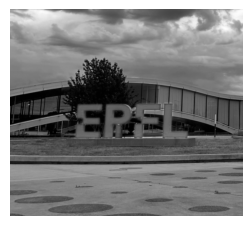

In [5]:
from PIL import Image
image = Image.open('epfl.png')
#making EPFL image greyscale same as Fashion MNIST images
transform_epfl_image = transforms.Compose(
    [transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])])
image = transform_epfl_image(image)[0:1].unsqueeze(0) #we are taking only one channel and adding batch dimention
plot_images(image, results_path=None, show=True)

# Implement DDPM

Diffusion models define a Markov chain of diffusion steps to slowly add random noise to data and then learn to reverse the diffusion process to construct desired data samples from the noise.


The Markov chain of forward (reverse) diffusion process of generating a sample by slowly adding (removing) noise.

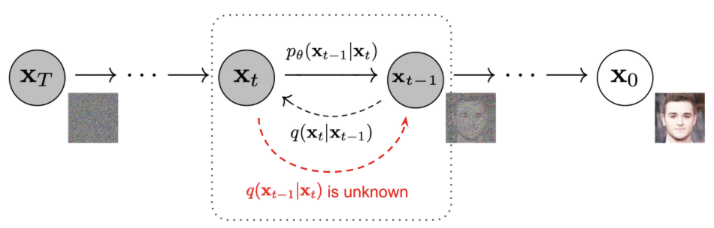

In [7]:
#initialise variables that will be further needed for diffusion model

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Using device:', device)

Using device: cuda


## Forward diffusion process
Given a data point sampled from a real data distribution $x_0 \sim q(x)$, let us define a forward diffusion process in which we add small amount of Gaussian noise to the sample in $T$ steps, producing a sequence of noisy samples $x_1, ..., x_T$. The step sizes are controlled by a variance schedule ${\beta_t \in (0, 1)}_{t=1}^T$.
The forward process is defined as:
$$q(x_t |  x_{t-1}) = \mathcal{N}(x_t; \sqrt{1 - \beta_t} x_{t-1}, \beta_t\mathbf{I}),$$
and the full forward trajectory is:
$$q(x_{1:T} |  x_0) = \prod^T_{t=1} q(x_t |  x_{t-1}).$$

The data sample $x_0$ gradually loses its distinguishable features as the step $t$ becomes larger. Eventually when $T \to \infty$, $x_T$ is equivalent to an isotropic Gaussian distribution.

A nice property of the above process is that we can sample  at any arbitrary time step  in a closed form using reparameterization trick. Let $\alpha_t = 1 - \beta_t$ and $\bar{\alpha}_t = \prod_{i=1}^t \alpha_i$. Then, sampling from $q(x_t | x_{t-1})$:
$$\begin{aligned}
x_t
&= \sqrt{\alpha_t}x_{t-1} + \sqrt{1 - \alpha_t}\boldsymbol{\epsilon}_{t-1} & \text{ , where } \boldsymbol{\epsilon}_{T-1}, \boldsymbol{\epsilon}_{T-2}, \dots  \boldsymbol{\epsilon}_{0} \sim \mathcal{N}(\mathbf{0}, \mathbf{I}) \\
&= \sqrt{\alpha_t \alpha_{t-1}} x_{t-2} + \sqrt{1 - \alpha_t \alpha_{t-1}} \bar{\boldsymbol{\epsilon}}_{t-2} & \text{ , where } \bar{\boldsymbol{\epsilon}}_{t-2} \text{ merges two Gaussians (*).} \\
&= \dots \\
&= \sqrt{\bar{\alpha}_t}x_0 + \sqrt{1 - \bar{\alpha}_t}\boldsymbol{\epsilon} & \text{ , where } \boldsymbol{\epsilon} = \boldsymbol{\epsilon_0}. \\
\end{aligned}$$

The closed form is: $\begin{aligned}
q(x_t |  x_0) &= \mathcal{N}(x_t; \sqrt{\bar{\alpha}_t} x_0, (1 - \bar{\alpha}_t)\mathbf{I}).
\end{aligned}$

Recall that a linear combination of two independent Gaussians distributions, is a Gaussian distribution. In particular, if $X \sim \mathcal{N}(0, \mathbf{I})$, and $Y \sim \mathcal{N}(0, \mathbf{I})$, and if $X$ and $Y$ are independent, then $aX + bY \sim \mathcal{N}(0, (a^2 + b^2)\mathbf{I})$.

This means that
$\sqrt{(1-\alpha_t)}\boldsymbol{\epsilon_{t-1}} + \sqrt{\alpha_t (1-\alpha_{t-1})} \boldsymbol{\epsilon_{t-2}}=  \sqrt{1 - \alpha_t \alpha_{t-1}} \bar{\boldsymbol{\epsilon}}_{t-2}$.

Usually, we can afford a larger update step when the sample gets noisier, so $\beta_1 < \beta_2 < \dots < \beta_T$ and therefore  $\bar{\alpha}_1 > \dots > \bar{\alpha}_T$

## Variance schedule

First, let's define the variance schedule to compute $\beta_t$. The simplest is the linear scheduler, but more advanced schedulers can give better results. In fact, one can define a variance schedule, which can be linear, quadratic, cosine etc. The authors of DDPM paper[1] utilized a linear schedule increasing from $\beta_1 = 10^{-4}$ to $\beta_T = 0.02$.


In [8]:
def linear_beta_schedule(n_diffusion_timesteps):
    '''
    n_diffusion_timesteps: number of diffusion timesteps
    '''
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, n_diffusion_timesteps)

We would also need some utility function that will help us with coding.

In [9]:
# utility functions
def extract(a, timestamps, x_shape):
    """
    Extracts coefficients at specified timesteps (timestamps),
    then reshapes to [batch_size, 1, 1, ...] for further manipulations.
    The function also puts the outputted vector on the same device as the
    device of timestamps.
      e.g., timestamps=[10,11], x_shape=[b,c,h,w] --> out.shape = [2,1,1,1]
      e.g., timestamps=[7,12,15,20], x_shape=[b,h,w] --> out.shape = [4,1,1]
    :param a: 1-D torch tensor.
    :param timesteps: a tensor of timestamps to extract.
    :param x_shape: a shape of tensor with which outputted tensor will further
                    interact with. The number of dimentions of outputted
                    vector should match the number of dimentions in x_shape,
                    so that further manipulations to vectors can be done.
    :return: a tensor of shape [batch_size, 1, 1,...]
    """
    batch_size, = timestamps.shape
    assert x_shape[0] == batch_size
    out = a.to(device=timestamps.device).gather(-1, timestamps)
    assert out.shape[0] == batch_size and len(out.shape) == 1
    out = torch.reshape(out, [batch_size] + ((len(x_shape) - 1) * [1]))
    return out


Class ```DiffusionProcessBaseVariablesPrecompute``` below is predefined for you. It initialises $\beta$ and $\alpha$ for each timestamp and precomputes additional variables that you use in  ``` ForwardDiffusionProcess```  and ```ReverseDiffusionProcess``` classes. Each variable initialised in ```DiffusionProcessBaseVariablesPrecompute``` is a torch array of size (```n_diffusion_timesteps```, ), where values are specified values precomputed for each timestemp $t$.

Additional variables precomputed in the class are:
\
```alphas_cumprod[i]``` = $\bar{\alpha}_i$ \
```alphas_cumprod_prev[i]``` = $\bar{\alpha}_{i - 1}$ \

```sqrt_alphas_cumprod[i]``` = $\sqrt{\bar{\alpha}_i}$ \
```sqrt_one_minus_alphas_cumprod[i]``` = $\sqrt{1 - \bar{\alpha}_i}$


In [10]:
# You are not supposed to change this class!
class DiffusionProcessBaseVariablesPrecompute:
    def __init__(self, n_diffusion_timesteps):
        super().__init__()
        self.n_diffusion_timesteps = n_diffusion_timesteps
        # compute betas
        self.betas = linear_beta_schedule(n_diffusion_timesteps=n_diffusion_timesteps)

        #compute alphas
        self.alphas = 1. - self.betas

        # compute cumulative product of alphas
        # the element i is a cumulative product of all the alphas with indexes <= i.
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)

        # compute cumulative product of alphas
        # the element i is a cumulative product of all the alphas with indexes <= i - 1.
        self.alphas_cumprod_prev = torch.cat([torch.tensor([1.], device=self.alphas_cumprod.device, dtype=self.alphas_cumprod.dtype),
                                                      self.alphas_cumprod[:-1]])

        #compute a square root of alphas_cumprod
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)

        #compute a square root of (1 - alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod)


In [11]:
#implement forward diffusion process
class ForwardDiffusionProcess(DiffusionProcessBaseVariablesPrecompute):
    def __init__(self, n_diffusion_timesteps):
        super().__init__(n_diffusion_timesteps)
        '''
        super function initialises a parent class DiffusionProcessBaseVariablesPrecompute,
        which when initialises precomputed variables like self.betas, self.alphas,
        self.alphas_cumprod etc. You can now use these variables inside
        ForwardDiffusionProcess class (e.g. self.betas).
        '''

    # forward diffusion (using the nice property of a closed form)
    def forward_diffusion_sample(self, x_0, t, noise=None):
        '''

        Sample x_t at a timestemp t using nice property of a closed form. Return x_t.
        :param x_0: starting x_0 image
        :param t: timestamp
        :param noise: epsilon, If noise == None - generate a random noise,
                      else start from a given noise
        :return: x_t

        Remember that you might need to adjust the shapes of the variables you
        use with 'extract' function defined above.
        '''

        # x_t = ...
        # YOUR CODE HERE
        t = torch.clamp(t, max=self.sqrt_alphas_cumprod.shape[0]-1)
        if noise is None:
            noise = torch.randn_like(x_0)

        sqrt_alphas_cumprod_t        = extract(self.sqrt_alphas_cumprod,        t, x_0.shape)
        sqrt_one_minus_alphas_cumprod_t = extract(self.sqrt_one_minus_alphas_cumprod, t, x_0.shape)

        x_t = sqrt_alphas_cumprod_t * x_0 + sqrt_one_minus_alphas_cumprod_t * noise
        return x_t

    def generate_noisy_image(self, x_0, noise=None):
        '''
        :param x_0: starting x_0 image
        :param noise: epsilon, If noise == None - generate a random noise,
                      else start from a given noise
        :return: list_of_x_t
        '''
        # list_of_x_t = ... list of images generated at timestamp t starting from 0 to T
        # YOUR CODE HERE
        device     = x_0.device
        batch_size = x_0.shape[0]
        
        list_of_x_t = [x_0]                     
        
        for t in range(1, self.n_diffusion_timesteps):
            t_tensor = torch.full((batch_size,), t, device=device, dtype=torch.long)
            list_of_x_t.append(self.forward_diffusion_sample(x_0, t_tensor))
        
        list_of_x_t.append(torch.randn_like(x_0))
        return list_of_x_t

In [12]:
diffusion_forward_process = ForwardDiffusionProcess(n_diffusion_timesteps=300)
print(f'Created a forward diffusion process with {diffusion_forward_process.n_diffusion_timesteps} timestemps')

Created a forward diffusion process with 300 timestemps


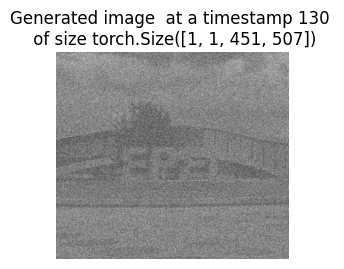

In [13]:
#noise EPFL image

t = torch.tensor([130]).long()

x_t = diffusion_forward_process.forward_diffusion_sample(image, t, noise=None)

assert x_t.shape == image.shape

plot_images(x_t, results_path=None, show=True, titles=[f'Generated image  at a timestamp {np.asarray(t)[0]} \n of size {x_t.shape}'])

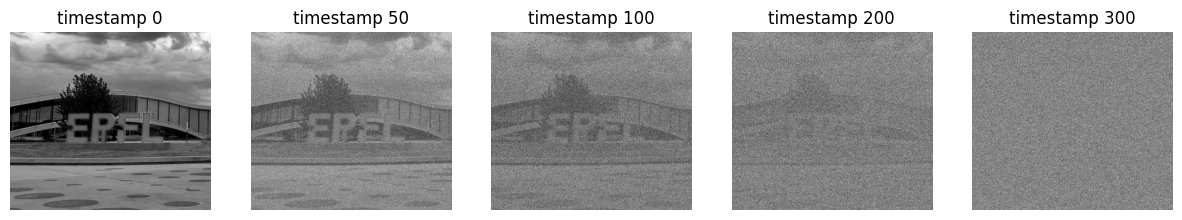

In [14]:
# noise EPFL image at different timesteps
epfl_image_list_of_x_t = diffusion_forward_process.generate_noisy_image(image)
plot_torch_images_of_selected_indexes(epfl_image_list_of_x_t, indexes_to_plot=[0, 50, 100, 200, 300], results_path=None, show=True, images_in_reversed_order=False)

## Reverse diffusion process
As $T \rightarrow \infty$, the latent $x_t$ becomes a nearly isotropic (where the covariance matrix is represented by the diagonal matrix) Gaussian distribution. Therefore, if we knew the reverse distribution $q(x_{t-1}| x_t)$, we could sample $x_t$ from $\mathcal{N}(\mathbf{0}, \mathbf{I})$, run the reverse process and acquire a sample from $q(x_0)$, generating a novel data point from the original data distribution.

In practical terms, we don't know $q(x_{t-1}| x_t)$. We need to learn a model $p_{\theta}$ to approximate these conditional probabilities in order to run the reverse diffusion process. Intuitively, since we use a Gaussian distribution to model the forward process, we can also use a normal distribution to model the reverse process. We can choose $p_{\theta}$ to be Gaussian and just parameterize the mean and variance:
$$
p_\theta(x_{t-1} |  x_t) = \mathcal{N}(x_{t-1}; \boldsymbol{\mu}_\theta(x_t, t), \boldsymbol{\Sigma}_\theta(x_t, t)).
$$  By additionally conditioning the model on timestep $t$ it will learn to predict the Gaussian parameters, mean $\boldsymbol{\mu}_\theta(x_t, t)$ and covariance matrix $\boldsymbol{\Sigma}_\theta(x_t, t)$, for each timestamp $t$.

If we apply the reverse formula for all timesteps $p_\theta(x_{0:T})$ we can go from $x_T$ to the $x_0$ generating a new sample out of the $q(x_0)$ distribution. The reverse formula for all timesteps, which is also called a trajectory is:

$$
p_\theta(x_{0:T}) = p(x_T) \prod^T_{t=1} p_\theta(x_{t-1} |  x_t) $$






## Training
We can train the diffusion model by optimising the negative log-likelihood of the training data $- \log p_\theta(x_0) $, which can be rewritten to be a combination of several KL-divergence and entropy term (Evidence Lower Bound).
$$
\begin{aligned}
L_\text{VLB} = \mathbb{E}_q [\underbrace{D_\text{KL}(q(x_T |  x_0) \parallel p_\theta(x_T))}_{L_T} + \sum_{t=2}^T \underbrace{D_\text{KL}(q(x_{t-1} |  x_t, x_0) \parallel p_\theta(x_{t-1} | x_t))}_{L_{t-1}} \underbrace{- \log p_\theta(x_0 | x_1)}_{L_0} ]
\end{aligned}
$$
$L_T$ is constant and can be ignored during training because $q$ has no learnable parameters and $x_t$ is a Gaussian noise.


(*) Details on how the loss can be rewritten, however you don't have to dive deep in them

$$\begin{aligned}
- \log p_\theta(x_0)
&\leq - \log p_\theta(x_0) + D_\text{KL}(q(x_{1:T}| x_0) \| p_\theta(x_{1:T}| x_0) ) & \small{\text{; KL is non-negative}}\\
&= - \log p_\theta(x_0) + \mathbb{E}_{x_{1:T}\sim q(x_{1:T} |  x_0)} \Big[ \log\frac{q(x_{1:T}| x_0)}{p_\theta(x_{0:T}) / p_\theta(x_0)} \Big] \\
&= - \log p_\theta(x_0) + \mathbb{E}_q \Big[ \log\frac{q(x_{1:T}| x_0)}{p_\theta(x_{0:T})} + \log p_\theta(x_0) \Big] \\
&= \mathbb{E}_q \Big[ \log \frac{q(x_{1:T}| x_0)}{p_\theta(x_{0:T})} \Big] \\
\text{Let }L_\text{VLB}
&= \mathbb{E}_{q(x_{0:T})} \Big[ \log \frac{q(x_{1:T}| x_0)}{p_\theta(x_{0:T})} \Big] \geq - \mathbb{E}_{q(x_0)} \log p_\theta(x_0)
\end{aligned}$$

$$
\begin{aligned}
L_\text{VLB}
&= \mathbb{E}_{q( x_{0:T})} \Big[ \log\frac{q( x_{1:T}\vert x_0)}{p_\theta( x_{0:T})} \Big] \\
&= \mathbb{E}_q \Big[ \log\frac{\prod_{t=1}^T q( x_t\vert x_{t-1})}{ p_\theta( x_T) \prod_{t=1}^T p_\theta( x_{t-1} \vert x_t) } \Big] \\
&= \mathbb{E}_q \Big[ -\log p_\theta( x_T) + \sum_{t=1}^T \log \frac{q( x_t\vert x_{t-1})}{p_\theta( x_{t-1} \vert x_t)} \Big] \\
&= \mathbb{E}_q \Big[ -\log p_\theta( x_T) + \sum_{t=2}^T \log \frac{q( x_t\vert x_{t-1})}{p_\theta( x_{t-1} \vert x_t)} + \log\frac{q( x_1 \vert  x_0)}{p_\theta( x_0 \vert  x_1)} \Big] \\
&= \mathbb{E}_q \Big[ -\log p_\theta( x_T) + \sum_{t=2}^T \log \Big( \frac{q( x_{t-1} \vert  x_t,  x_0)}{p_\theta( x_{t-1} \vert x_t)}\cdot \frac{q( x_t \vert  x_0)}{q( x_{t-1}\vert x_0)} \Big) + \log \frac{q( x_1 \vert  x_0)}{p_\theta( x_0 \vert  x_1)} \Big] \\
&= \mathbb{E}_q \Big[ -\log p_\theta( x_T) + \sum_{t=2}^T \log \frac{q( x_{t-1} \vert  x_t,  x_0)}{p_\theta( x_{t-1} \vert x_t)} + \sum_{t=2}^T \log \frac{q( x_t \vert  x_0)}{q( x_{t-1} \vert  x_0)} + \log\frac{q( x_1 \vert  x_0)}{p_\theta( x_0 \vert  x_1)} \Big] \\
&= \mathbb{E}_q \Big[ -\log p_\theta( x_T) + \sum_{t=2}^T \log \frac{q( x_{t-1} \vert  x_t,  x_0)}{p_\theta( x_{t-1} \vert x_t)} + \log\frac{q( x_T \vert  x_0)}{q( x_1 \vert  x_0)} + \log \frac{q( x_1 \vert  x_0)}{p_\theta( x_0 \vert  x_1)} \Big]\\
&= \mathbb{E}_q \Big[ \log\frac{q( x_T \vert  x_0)}{p_\theta( x_T)} + \sum_{t=2}^T \log \frac{q( x_{t-1} \vert  x_t,  x_0)}{p_\theta( x_{t-1} \vert x_t)} - \log p_\theta( x_0 \vert  x_1) \Big] \\
&= \mathbb{E}_q [\underbrace{D_\text{KL}(q( x_T \vert  x_0) \parallel p_\theta( x_T))}_{L_T} + \sum_{t=2}^T \underbrace{D_\text{KL}(q( x_{t-1} \vert  x_t,  x_0) \parallel p_\theta( x_{t-1} \vert x_t))}_{L_{t-1}} \underbrace{- \log p_\theta( x_0 \vert  x_1)}_{L_0} ]
\end{aligned}
$$

### Manipulation
For $L_t$ we need to know how to represent $q(x_{t-1} |  x_t, x_0)$\
The reverse conditional probability is tractable when conditioned on $x_0$,
$$q(x_{t-1} |  x_t, x_0) = \mathcal{N}(x_{t-1}; \color{blue}{\tilde{\boldsymbol{\mu}}}(x_t, x_0), \color{red}{\tilde{\beta}_t} \mathbf{I})$$ (we will further denote $ \color{blue}{\tilde{\boldsymbol{\mu}_t}} = \color{blue}{\tilde{\boldsymbol{\mu}}}(x_t, x_0)$ and $ \color{red}{\tilde{\beta}_t}  = \color{red}{\tilde{\beta}_t} \mathbf{I}$)

Using Bayes’ rule for $q(x_{t-1} |  x_t, x_0) $, we can prove that mean and variance $\color{blue}{\tilde{\boldsymbol{\mu}_t}}$ and $\color{red}{\tilde{\beta}_t}$ can be parametrised as $
\tilde{\boldsymbol{\mu}}_t = \frac{1}{\sqrt{\alpha_t}} \Big( x_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \boldsymbol{\epsilon}_t \Big)$
and $\tilde{\beta}_t = \frac{1 - \bar \alpha_{t-1}}{1 - \bar \alpha_{t}} \beta_t$. (Details of how the Bayes' rule is implied can be found in (**)).

Recall that we want to learn a neural network to approximate the conditioned probability distributions in the reverse diffusion process, $p_\theta(x_{t-1} \vert x_t) = \mathcal{N}(x_{t-1}; \boldsymbol{\mu}_\theta(x_t, t), \boldsymbol{\Sigma}_\theta(x_t, t))$. As such, we want to train $\boldsymbol{\mu}_\theta(x_t, t)$ to predict $\tilde{\boldsymbol{\mu}}_t = \frac{1}{\sqrt{\alpha_t}} \Big( x_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \boldsymbol{\epsilon}_t \Big)$ (we don't need to learn $\boldsymbol{\Sigma}_\theta(x_t, t)$ since it can be replaced with $\tilde{\beta}_t$).
Therefore, the only thing we don't know from $\tilde{\boldsymbol{\mu}}_t$ is $\boldsymbol{\epsilon}_t$. As a result, instead of training the network to predict $\boldsymbol{\mu}_\theta(x_t, t)$ we can train a network to predict $\boldsymbol{\epsilon}_\theta(x_t, t)$ to approximate $\boldsymbol{\epsilon}_t$.




### Simplification of the loss
The authors of DDPM suggested that the loss $L_t$ then can be reparametrisized  and simplified into $$\begin{aligned}
L_t^\text{simple}
&= \mathbb{E}_{t \sim [1, T], x_0, \boldsymbol{\epsilon}_t} \Big[\|\boldsymbol{\epsilon}_t - \boldsymbol{\epsilon}_\theta(x_t, t)\|^2 \Big] \\
&= \mathbb{E}_{t \sim [1, T], x_0, \boldsymbol{\epsilon}_t} \Big[\|\boldsymbol{\epsilon}_t - \boldsymbol{\epsilon}_\theta(\sqrt{\bar{\alpha}_t}x_0 + \sqrt{1 - \bar{\alpha}_t}\boldsymbol{\epsilon}_t, t)\|^2 \Big]
\end{aligned}$$

You need to implement this simplified loss.

<!-- Basically, it;s a simple MSE between actual noise on step $t$, $\boldsymbol{\epsilon}_t$ -->

(**)
Details of how the Bayes’ rule is applied and how we get the parametrisation of $\color{blue}{\tilde{\boldsymbol{\mu}_t}}$ and $\color{red}{\tilde{\beta}_t}$:
$$
\begin{aligned}
q(x_{t-1} |  x_t, x_0)
&= q(x_t |  x_{t-1}, x_0) \frac{ q(x_{t-1} |  x_0) }{ q(x_t |  x_0) } \\
&\propto \exp \Big(-\frac{1}{2} \big(\frac{(x_t - \sqrt{\alpha_t} x_{t-1})^2}{\beta_t} + \frac{(x_{t-1} - \sqrt{\bar{\alpha}_{t-1}} x_0)^2}{1-\bar{\alpha}_{t-1}} - \frac{(x_t - \sqrt{\bar{\alpha}_t} x_0)^2}{1-\bar{\alpha}_t} \big) \Big) \\
&= \exp \Big(-\frac{1}{2} \big(\frac{x_t^2 - 2\sqrt{\alpha_t} x_t \color{blue}{x_{t-1}} \color{black}{+ \alpha_t} \color{red}{x_{t-1}^2} }{\beta_t} + \frac{ \color{red}{x_{t-1}^2} \color{black}{- 2 \sqrt{\bar{\alpha}_{t-1}} x_0} \color{blue}{x_{t-1}} \color{black}{+ \bar{\alpha}_{t-1} x_0^2}  }{1-\bar{\alpha}_{t-1}} - \frac{(x_t - \sqrt{\bar{\alpha}_t} x_0)^2}{1-\bar{\alpha}_t} \big) \Big) \\
&= \exp\Big( -\frac{1}{2} \big( \color{red}{(\frac{\alpha_t}{\beta_t} + \frac{1}{1 - \bar{\alpha}_{t-1}})} x_{t-1}^2 - \color{blue}{(\frac{2\sqrt{\alpha_t}}{\beta_t} x_t + \frac{2\sqrt{\bar{\alpha}_{t-1}}}{1 - \bar{\alpha}_{t-1}} x_0)} x_{t-1} \color{black}{ + C(x_t, x_0) \big) \Big)}
\end{aligned}
$$, where $ C(x_t, x_0)$ is a function not involving $x_{t-1}$ and can be ignored.

According to the definition of Gaussian and the 'nice property' we get:
$$
\begin{aligned}
\tilde{\beta}_t
&= 1/(\frac{\alpha_t}{\beta_t} + \frac{1}{1 - \bar{\alpha}_{t-1}})
= 1/(\frac{\alpha_t - \bar{\alpha}_t + \beta_t}{\beta_t(1 - \bar{\alpha}_{t-1})})
= \color{green}{\frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t} \cdot \beta_t} \\
\tilde{\boldsymbol{\mu}}_t (x_t, x_0)
&= (\frac{\sqrt{\alpha_t}}{\beta_t} x_t + \frac{\sqrt{\bar{\alpha}_{t-1} }}{1 - \bar{\alpha}_{t-1}} x_0)/(\frac{\alpha_t}{\beta_t} + \frac{1}{1 - \bar{\alpha}_{t-1}}) \\
&= (\frac{\sqrt{\alpha_t}}{\beta_t} x_t + \frac{\sqrt{\bar{\alpha}_{t-1} }}{1 - \bar{\alpha}_{t-1}} x_0) \color{green}{\frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t} \cdot \beta_t} \\
&= \frac{\sqrt{\alpha_t}(1 - \bar{\alpha}_{t-1})}{1 - \bar{\alpha}_t} x_t + \frac{\sqrt{\bar{\alpha}_{t-1}}\beta_t}{1 - \bar{\alpha}_t} x_0\\
&= \frac{\sqrt{\alpha_t}(1 - \bar{\alpha}_{t-1})}{1 - \bar{\alpha}_t} x_t + \frac{\sqrt{\bar{\alpha}_{t-1}}\beta_t}{1 - \bar{\alpha}_t} \frac{1}{\sqrt{\bar{\alpha}_t}}(x_t - \sqrt{1 - \bar{\alpha}_t}\boldsymbol{\epsilon}_t)\\
&=\frac{1}{\sqrt{\alpha_t}} \Big( x_t - \frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}} \boldsymbol{\epsilon}_t \Big)
\end{aligned}
$$  
]
From the formulas above you can also see how you can express $\tilde{\boldsymbol{\mu}}_t $ through $x_0$ and $x_t$.

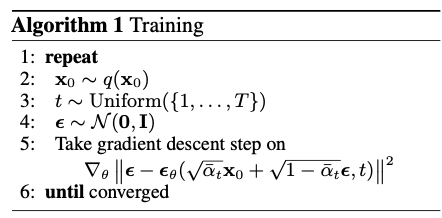

### Model

At timestamp $t$ to predict the noise $\boldsymbol{\epsilon}_\theta(x_t, t)$ we will use a Unet network that takes as input an image and a timestamp. The Unet applies positional encoding to the timestamp, this way conditioning the output on the timestamp, and concatenates an image and a timestamp embedding for further manipulations. You can see an sceme of the model below.

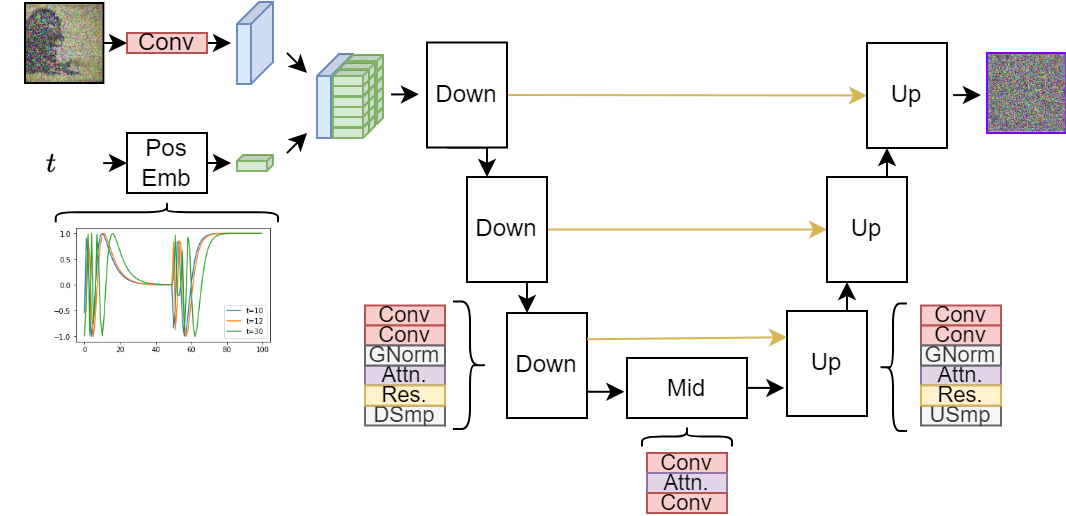

In [15]:
class Trainer():
    def __init__(self, n_diffusion_timesteps, model, device,
                 indexes_to_plot = [0, 50, 100, 150, 199]):


        self.n_diffusion_timesteps = n_diffusion_timesteps

        #initialising forward and reverse diffusion process
        self.diffusion_forward_process = ForwardDiffusionProcess(n_diffusion_timesteps=n_diffusion_timesteps)

        #diffusion reverse process is defined below
        self.diffusion_reverse_process = ReverseDiffusionProcess(n_diffusion_timesteps=n_diffusion_timesteps,
                                                                 model=model.to(device))
        #note that model is part of a diffusion reverse process (self.diffusion_reverse_process.model)


        self.device = device


        self.criterion = nn.MSELoss()

        self.optimizer = torch.optim.Adam(self.diffusion_reverse_process.model.parameters(), lr=1e-3)

        # we fix latent vectors so that during training you can see the progress of the diffusion model on the same latent
        self.fixed_x_T_for_check = torch.load('fixed_30_x_T_for_check.pt').to(self.device)
        self.indexes_to_plot = indexes_to_plot

        self.loss_log = []


        self.model_weights_path = 'diffusion_model_weights/' #path where the models are going to be saved
        if not os.path.exists(self.model_weights_path):
            os.mkdir(self.model_weights_path)

        self.report_images_path = 'diffusion_model_report_images/' #path where the report images are going to be saved
        if not os.path.exists(self.report_images_path):
            os.mkdir(self.report_images_path)



    def train_epoch(self, train_loader):
        for step, data in enumerate(train_loader):
            self.optimizer.zero_grad()

            #loss = ...
            # YOUR CODE HERE
            x_0, _ = data                                  
            x_0 = x_0.to(self.device)

            batch_size = x_0.shape[0]
            t = torch.randint(
                0, self.n_diffusion_timesteps, (batch_size,), device=self.device
            ).long()                                       

            noise = torch.randn_like(x_0)                   
            x_t   = self.diffusion_forward_process.forward_diffusion_sample(x_0, t, noise)

            noise_pred = self.diffusion_reverse_process.model(x_t, t)

            loss = self.criterion(noise_pred, noise)  

            if step % 100 == 0:
              print(f"step: {step} -- Loss: {loss.item():.3f}")

            loss.backward()
            self.optimizer.step()
            self.loss_log.append(loss.item())

    def plot_loss(self, epoch):
        #ploting the whole loss starting from the beginning of training
        plt.figure(figsize=(5, 5))
        plt.plot(self.loss_log, c='blue')
        plt.title('training loss')
        plt.savefig(self.report_images_path + f'diffusion_model_loss_ep{epoch}.jpg')
        plt.close()


    def evaluate(self, epoch, image_shape):
        fake_images = self.diffusion_reverse_process.generate_images(image_shape)
        plot_torch_images_of_selected_indexes(fake_images, self.indexes_to_plot, results_path=None, show=True)


        fake_images = self.diffusion_reverse_process.generate_images(image_shape, noise=self.fixed_x_T_for_check.to(self.device))
        plot_torch_images_of_selected_indexes(fake_images, self.indexes_to_plot,
                                              results_path=self.report_images_path + f'fixed_x_T_for_check_ep{epoch}.jpg', show=False)

        #save model weights
        torch.save(self.diffusion_reverse_process.model.state_dict(), self.model_weights_path + 'diffusion_model.pt')

        #plot losses
        self.plot_loss(epoch)


    def train(self, train_loader, n_epochs, image_shape):
        for epoch in range(n_epochs):

            print(f"\n\nEpoch: {epoch}")
            self.train_epoch(train_loader)

            self.evaluate(epoch, image_shape)


## Sampling

You can see that in the training loop we have a function that shows generated image. To generate this images we need to apply Sampling process which in diffusion models is done consecutively.
You have to implement it in the DiffusionReverseProcess

To sample  $x_{t - 1}$ from $x_t$ you need to get $\boldsymbol{\mu}_\theta(x_t, t)$ and $\boldsymbol{\Sigma}_\theta(x_t, t)$ depending on $\boldsymbol{\epsilon}_\theta(x_t, t)$.

The sampling process is explained below:

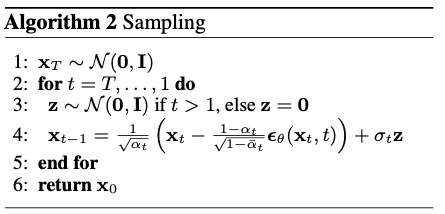

In [16]:
#implement reverse diffusion process
class ReverseDiffusionProcess(DiffusionProcessBaseVariablesPrecompute):
    def __init__(self, n_diffusion_timesteps, model):
        '''
        super() function initialises a parent class DiffusionProcessBaseVariablesPrecompute,
         which initialises precomputed variables like self.betas, self.alphas, self.alphas_cumprod etc.
        You can now use these variables inside ReverseDiffusionProcess class.
        '''
        super().__init__(n_diffusion_timesteps)


        '''
        model: model (\theta) that generates noise at step t from x_t
        '''
        self.model = model

        # calculations for posterior p_{\theta}(x_{t-1} | x_t)
        # self.posterior_variance = ... posterior variance
        # self.posterior_mean_coef_x_t = ... coefficient next to x_t for computation of p posterior mean
        # self.posterior_mean_coef_epsilon = ... coefficient next to epsilon for computation of p posterior mean
        # YOUR CODE HERE
        self.posterior_variance = (
            self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )

        self.posterior_mean_coef_x_t = 1.0 / torch.sqrt(self.alphas)
        self.posterior_mean_coef_epsilon = (1.0 - self.alphas) / (
            torch.sqrt(1.0 - self.alphas_cumprod) * torch.sqrt(self.alphas)
        )

    def p_posterior_mean_variance(self, x_t, t):
        '''
        Get mean and variance of p(x_{t-1} | x_t).
        '''
        # mean = ...
        # variance = ...
        # YOUR CODE HERE
        eps_theta = self.model(x_t, t)

        coef_x   = extract(self.posterior_mean_coef_x_t,      t, x_t.shape)
        coef_eps = extract(self.posterior_mean_coef_epsilon,  t, x_t.shape)

        mean     = coef_x * x_t - coef_eps * eps_theta
        variance = extract(self.posterior_variance, t, x_t.shape)
        return mean, variance

    def q_posterior_mean_variance(self, x_t, x_0, t):
        '''
        Get mean and variance of q(x_{t-1} | x_t, x_0).
        We want to compute it from x_0 and x_t to compare with the predicted p_posterior_mean_variance.
        To do that you need to express \tilde{\boldsymbol{\mu}_t} in terms of x_t and x_0.
        '''
        # mean = ...
        # variance = ...
        # YOUR CODE HERE
        coef1 = extract(
            torch.sqrt(self.alphas_cumprod_prev) * self.betas / (1.0 - self.alphas_cumprod),
            t,
            x_t.shape,
        )
        coef2 = extract(
            torch.sqrt(self.alphas)
            * (1.0 - self.alphas_cumprod_prev)
            / (1.0 - self.alphas_cumprod),
            t,
            x_t.shape,
        )

        mean = coef1 * x_0 + coef2 * x_t
        variance  = extract(self.posterior_variance, t, x_t.shape)
        return mean, variance


    @torch.no_grad()
    def generate_images_at_previous_timestamp(self, x_t, t):
        '''
        :param x_t: image at timestamp t
        :param t: timestamp
        :return x_t_minus_1 : Generate x_{t-1}. You have to use self.p_posterior_mean_variance function!
        '''
        # x_t_minus_1 = ...
        # YOUR CODE HERE
        batch_size = x_t.shape[0]
        mean, var = self.p_posterior_mean_variance(x_t, t)

        noise = torch.randn_like(x_t)
        nonzero_mask = (t != 0).float().view(batch_size, *((1,) * (len(x_t.shape) - 1)))
        x_t_minus_1 = mean + nonzero_mask * torch.sqrt(var) * noise
        return x_t_minus_1



    @torch.no_grad()
    def generate_images(self, image_shape, noise=None):
        '''
        :param noise: x_T, If noise == None - start from a random noise, else start from a given noise
        :return: list_of_x_t
        '''

        device = next(self.model.parameters()).device
        # list_of_x_t = ... list of images generated at timestamp t starting from T to 0
        # YOUR CODE HERE
        if noise is None:
            x_t = torch.randn(image_shape, device=device)
        else:
            x_t = noise.to(device)

        list_of_x_t = [x_t]                                  
        for t in range(self.n_diffusion_timesteps - 1, -1, -1):
            t_tensor = torch.full(
                (x_t.shape[0],), t, device=device, dtype=torch.long
            )
            x_t = self.generate_images_at_previous_timestamp(x_t, t_tensor)
            list_of_x_t.append(x_t)

        return list_of_x_t


<>:48: SyntaxWarning: invalid escape sequence '\m'
<>:48: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_1843/3111338186.py:48: SyntaxWarning: invalid escape sequence '\m'
  '''


# Train DDPM

In [17]:
n_diffusion_timesteps = 200
batch_size = 128
n_epochs = 10
image_size = 32
channels = 1 #Grayscale image


train_loader = load_fashion_mnist_dataset(batch_size)

device = "cuda" if torch.cuda.is_available() else "cpu"

from unet import Unet
model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)



/tmp/ipykernel_1843/3774727871.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.fixed_x_T_for_check = torch.load('fixed_30_x_T_for_check.pt').to(self.device)




Epoch: 0
step: 0 -- Loss: 1.161
step: 100 -- Loss: 0.316
step: 200 -- Loss: 0.183
step: 300 -- Loss: 0.094
step: 400 -- Loss: 0.093


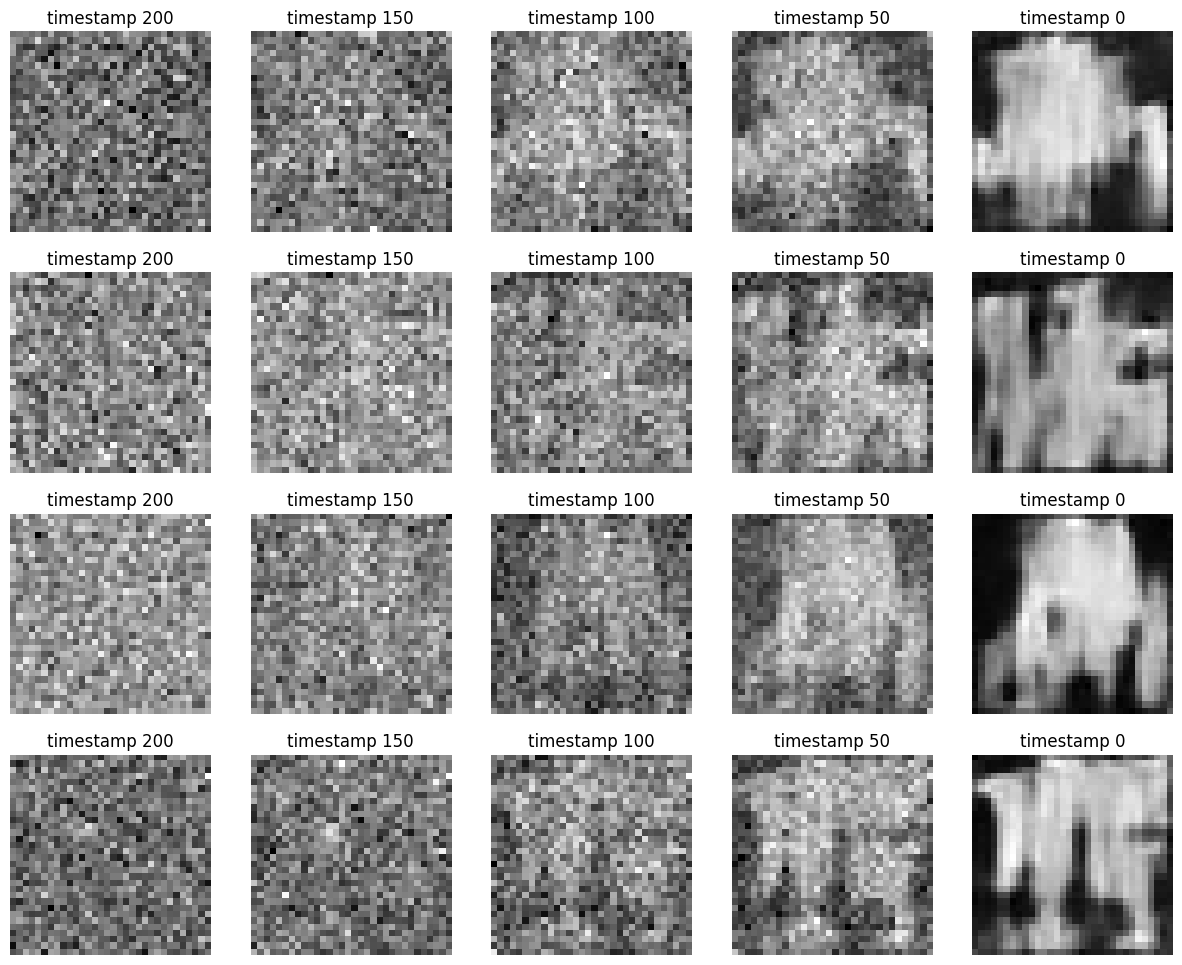



Epoch: 1
step: 0 -- Loss: 0.112
step: 100 -- Loss: 0.090
step: 200 -- Loss: 0.105
step: 300 -- Loss: 0.070
step: 400 -- Loss: 0.072


<Figure size 1500x9000 with 0 Axes>

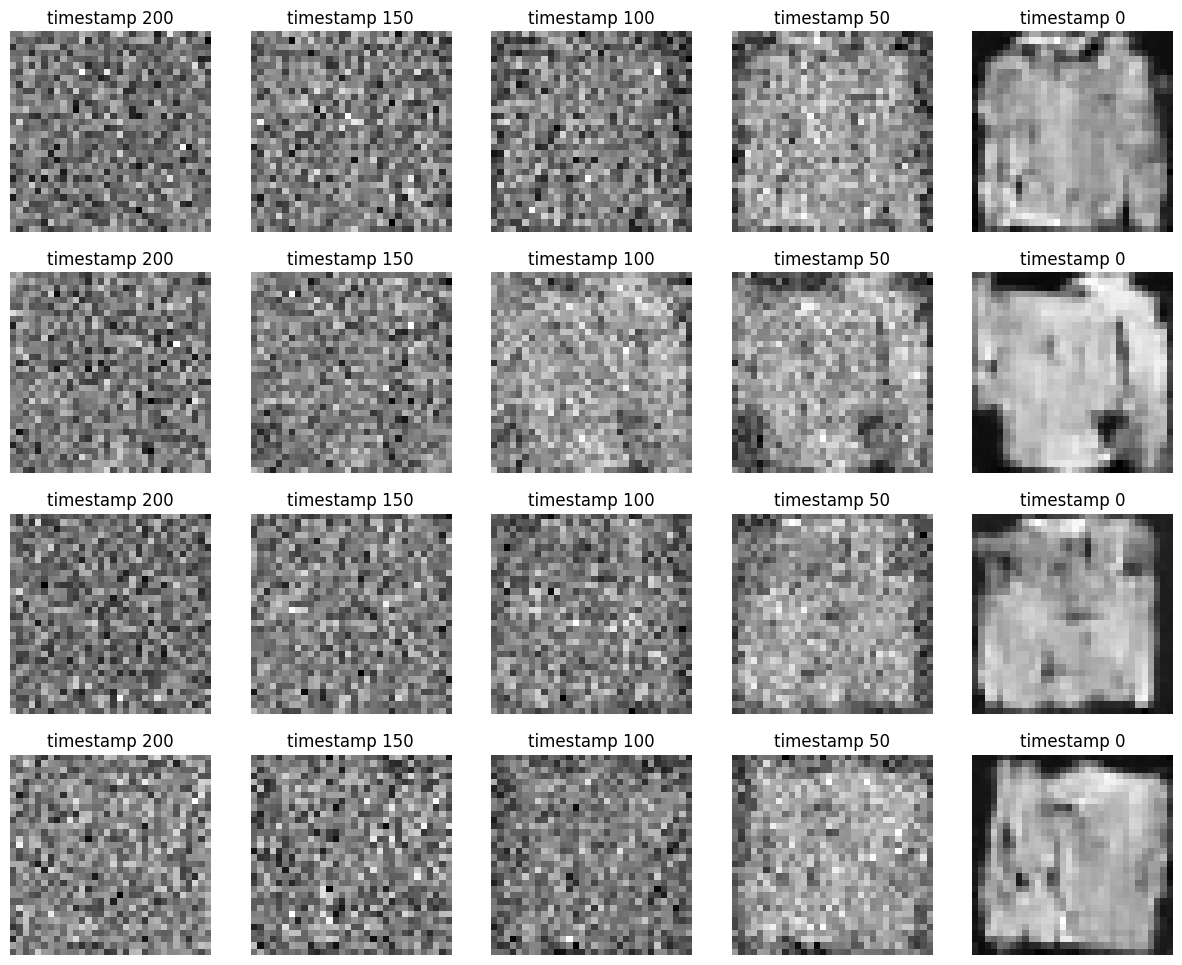



Epoch: 2
step: 0 -- Loss: 0.086
step: 100 -- Loss: 0.107
step: 200 -- Loss: 0.090
step: 300 -- Loss: 0.092
step: 400 -- Loss: 0.077


<Figure size 1500x9000 with 0 Axes>

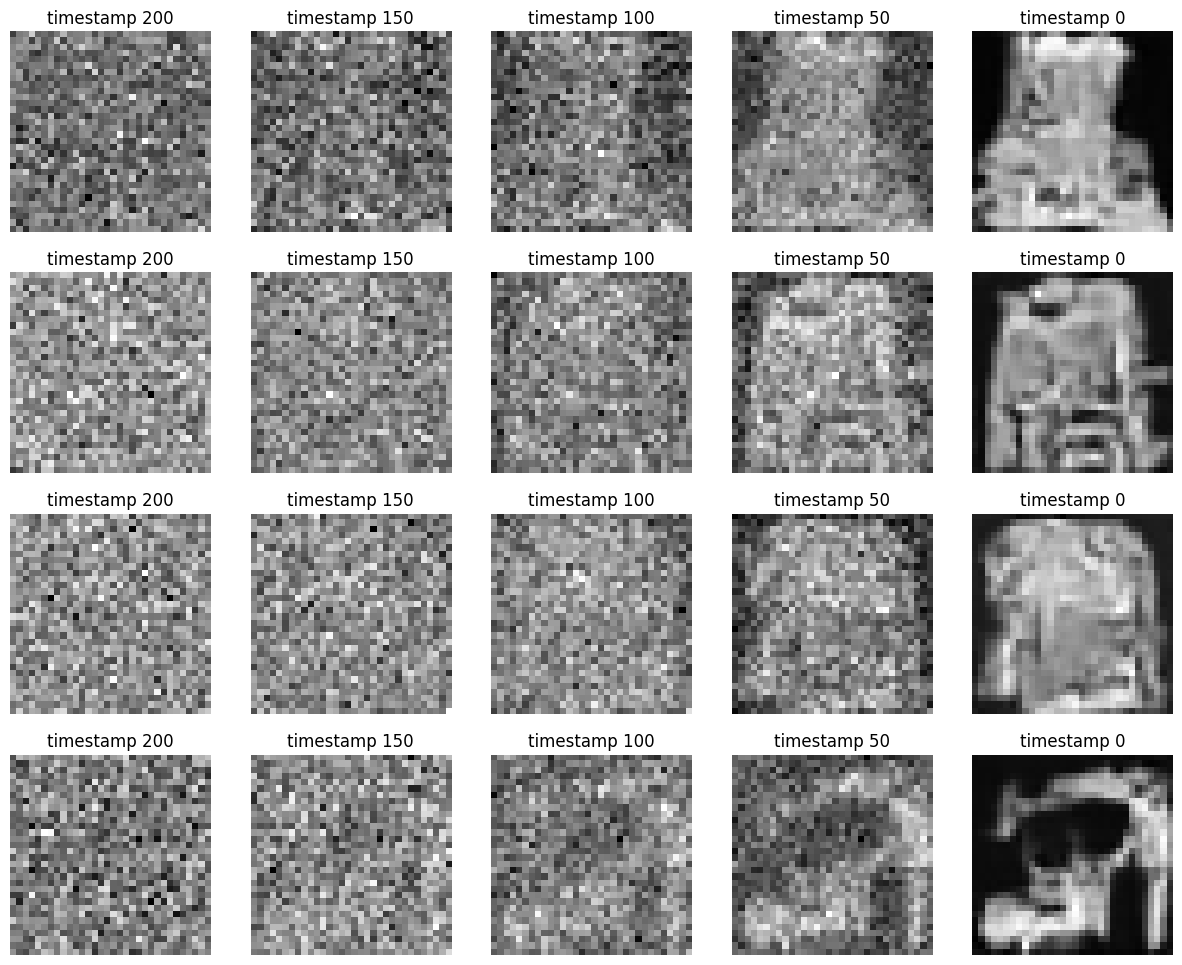



Epoch: 3
step: 0 -- Loss: 0.071
step: 100 -- Loss: 0.090
step: 200 -- Loss: 0.069
step: 300 -- Loss: 0.075
step: 400 -- Loss: 0.059


<Figure size 1500x9000 with 0 Axes>

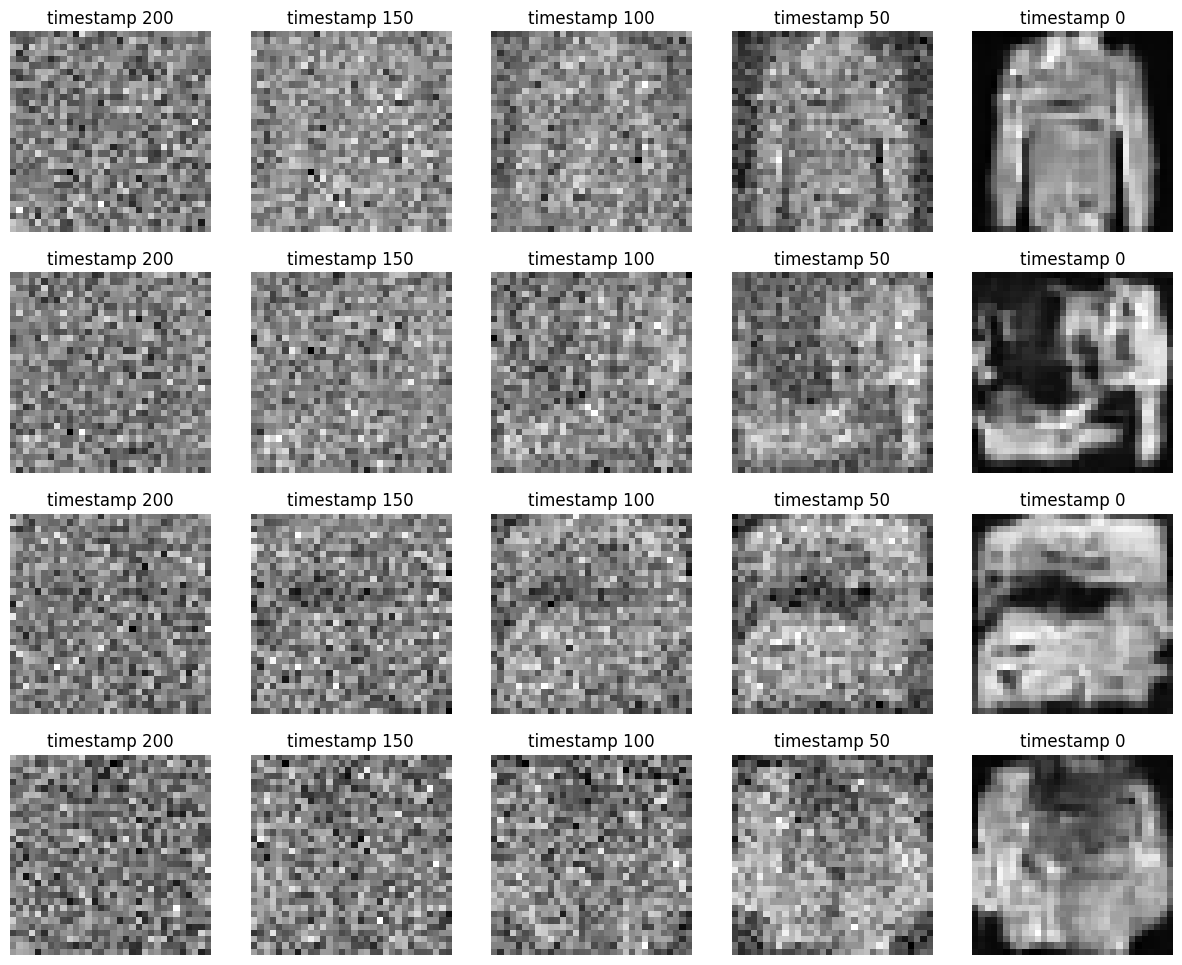



Epoch: 4
step: 0 -- Loss: 0.056
step: 100 -- Loss: 0.063
step: 200 -- Loss: 0.070
step: 300 -- Loss: 0.073
step: 400 -- Loss: 0.056


<Figure size 1500x9000 with 0 Axes>

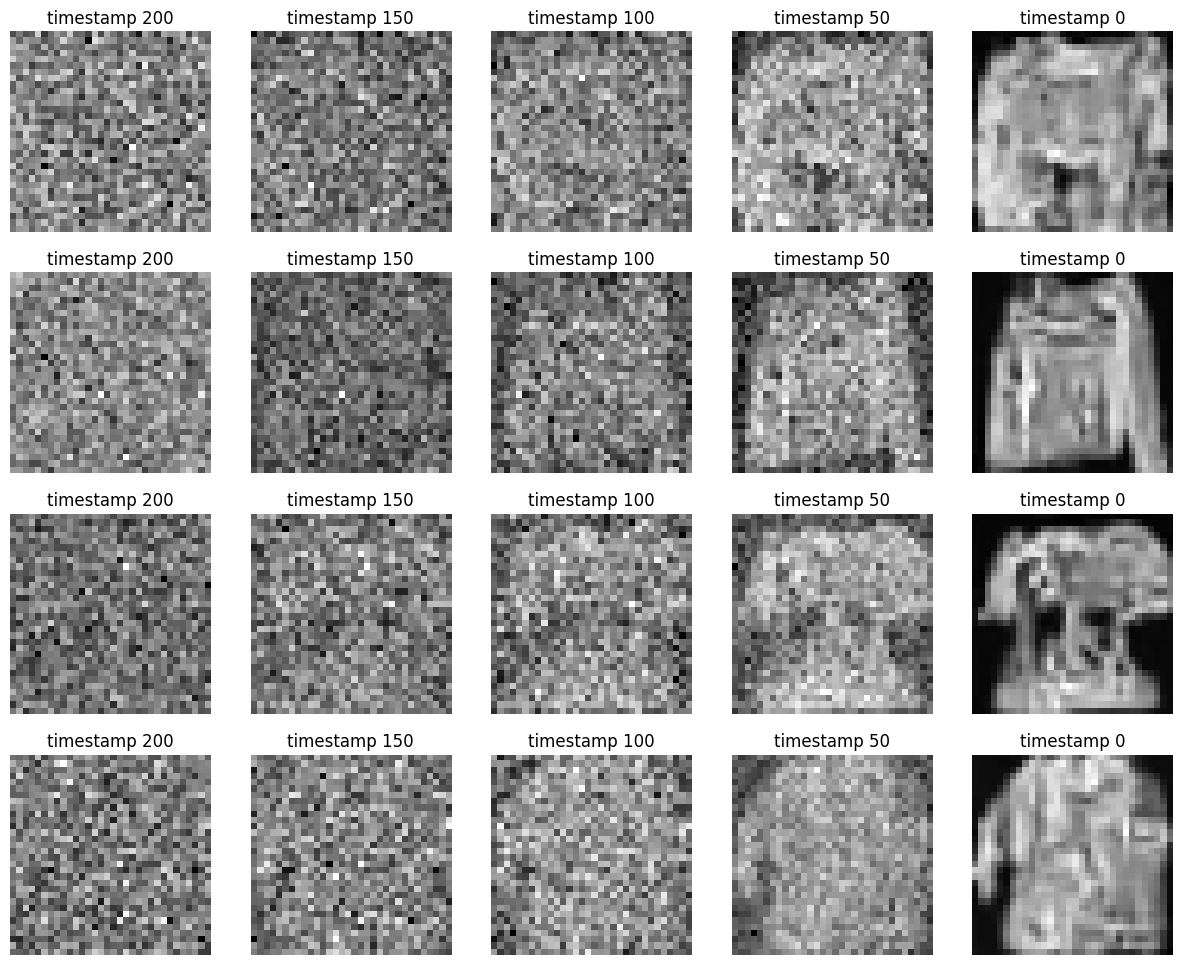



Epoch: 5
step: 0 -- Loss: 0.074
step: 100 -- Loss: 0.065
step: 200 -- Loss: 0.064
step: 300 -- Loss: 0.067
step: 400 -- Loss: 0.066


<Figure size 1500x9000 with 0 Axes>

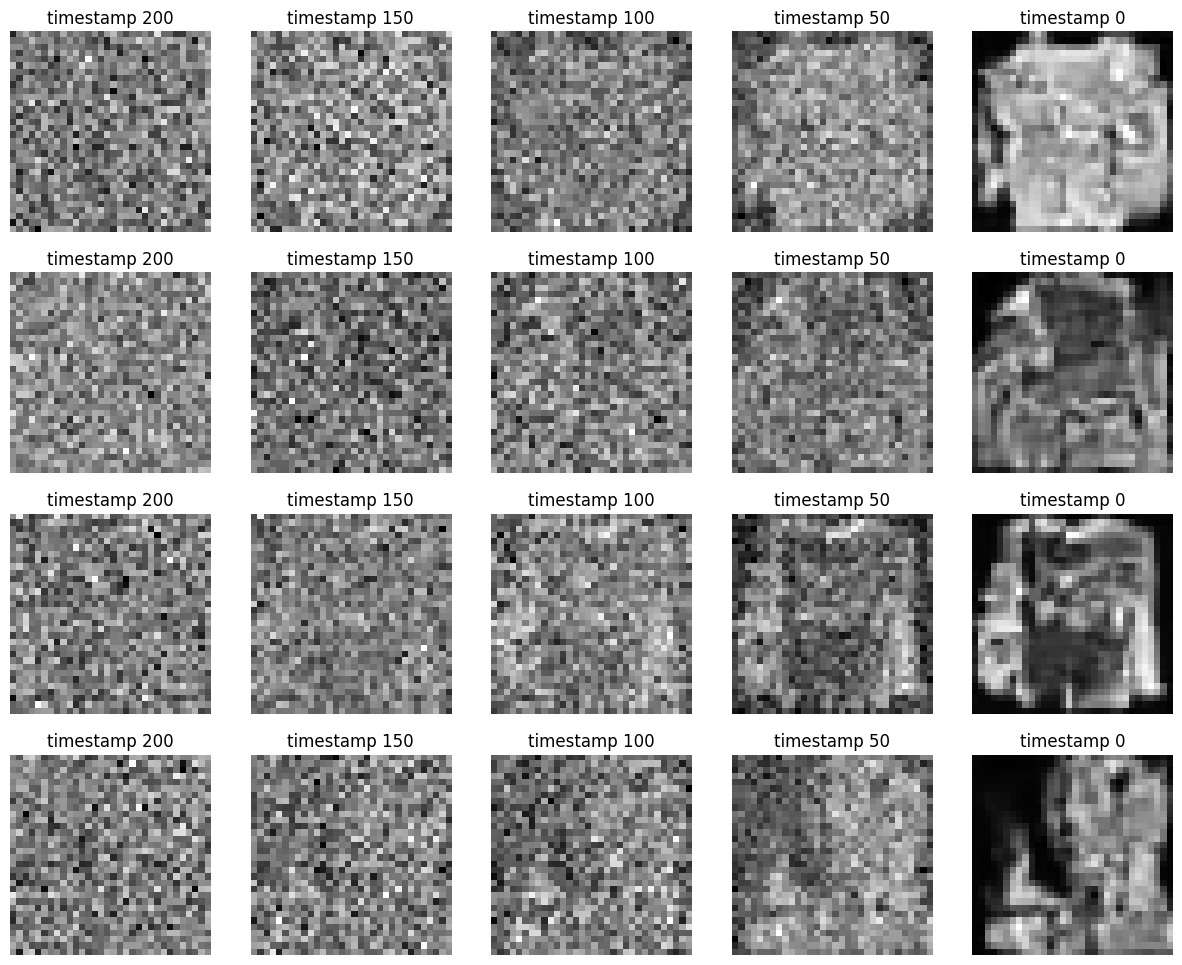



Epoch: 6
step: 0 -- Loss: 0.066
step: 100 -- Loss: 0.066
step: 200 -- Loss: 0.058
step: 300 -- Loss: 0.057
step: 400 -- Loss: 0.064


<Figure size 1500x9000 with 0 Axes>

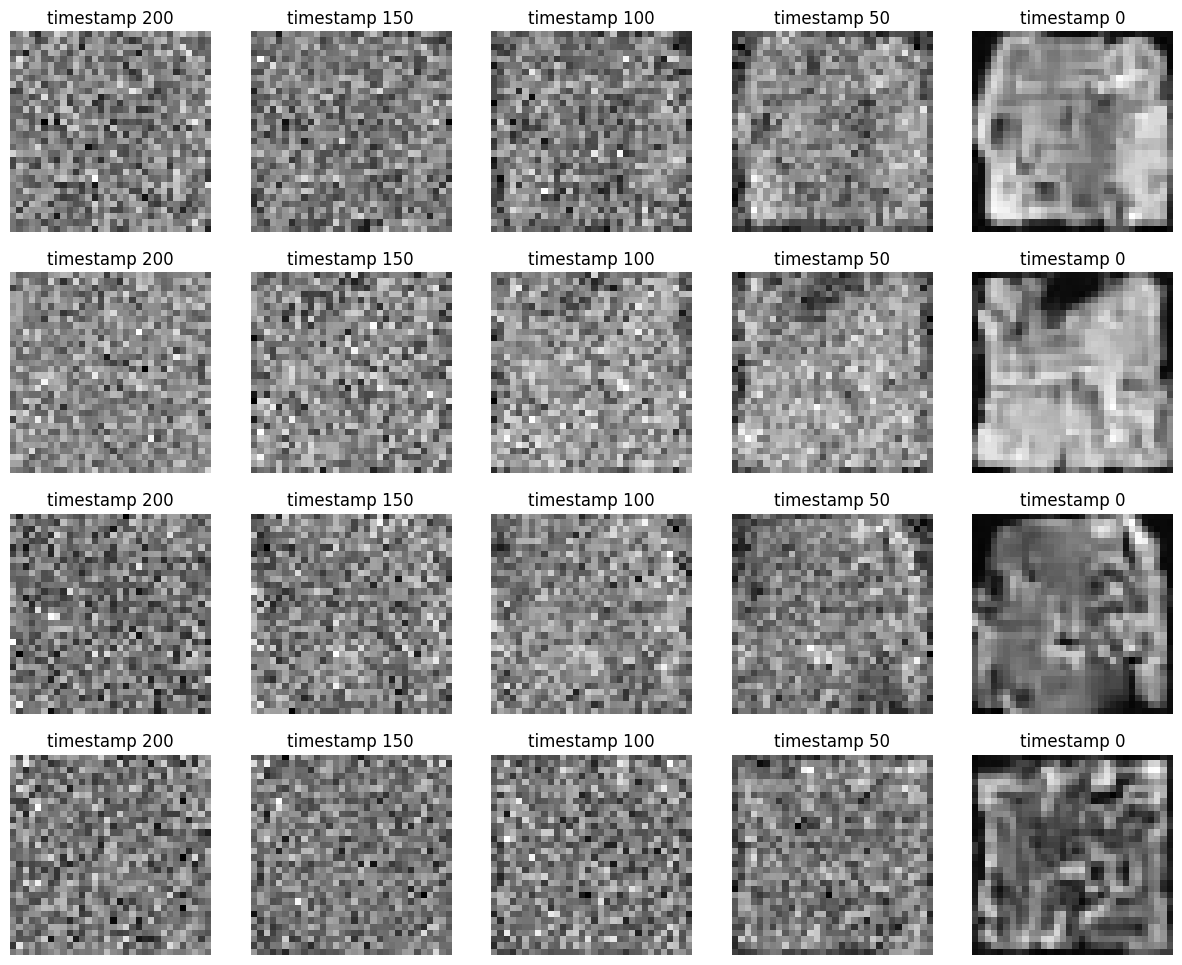



Epoch: 7
step: 0 -- Loss: 0.060
step: 100 -- Loss: 0.062
step: 200 -- Loss: 0.053
step: 300 -- Loss: 0.065
step: 400 -- Loss: 0.066


<Figure size 1500x9000 with 0 Axes>

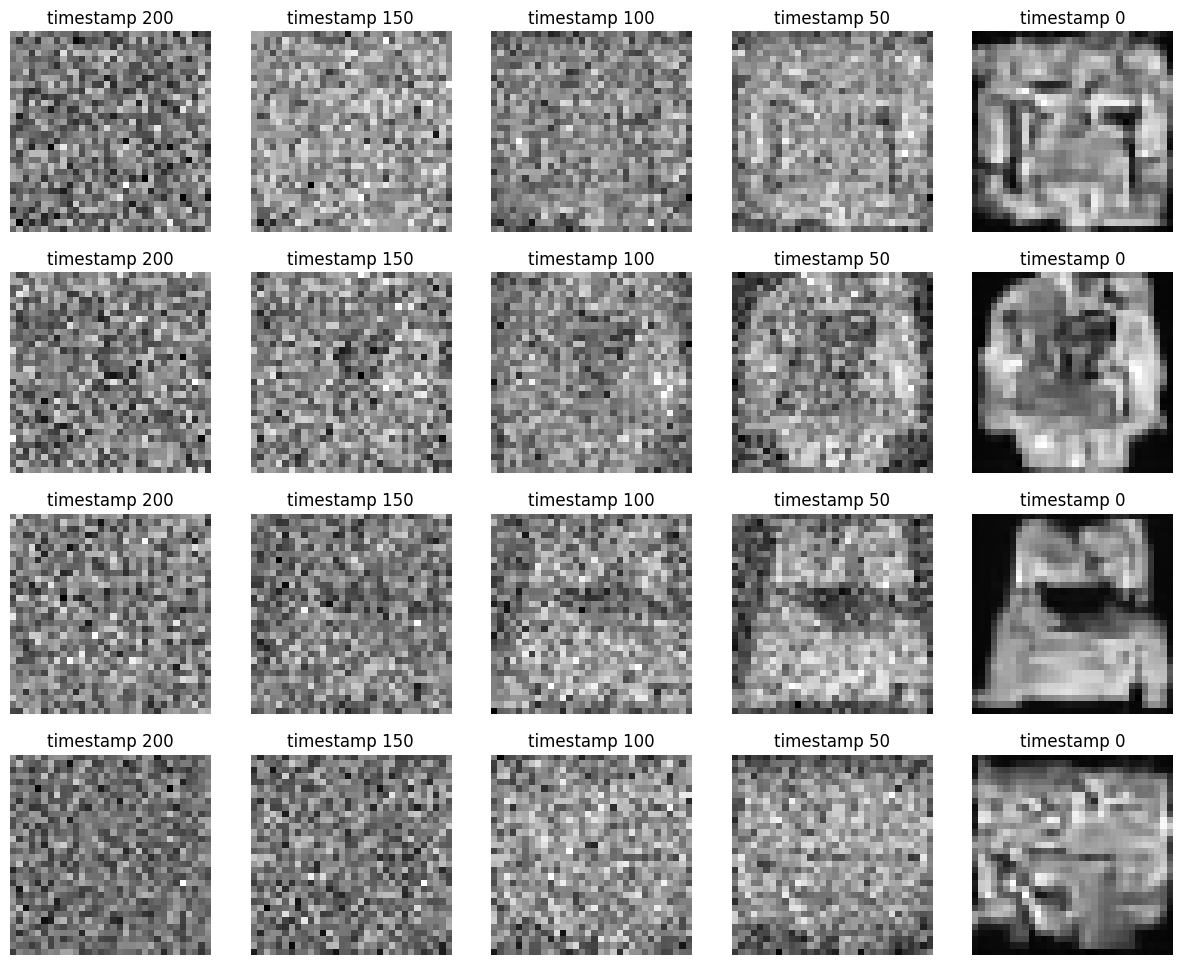



Epoch: 8
step: 0 -- Loss: 0.053
step: 100 -- Loss: 0.063
step: 200 -- Loss: 0.063
step: 300 -- Loss: 0.071
step: 400 -- Loss: 0.061


<Figure size 1500x9000 with 0 Axes>

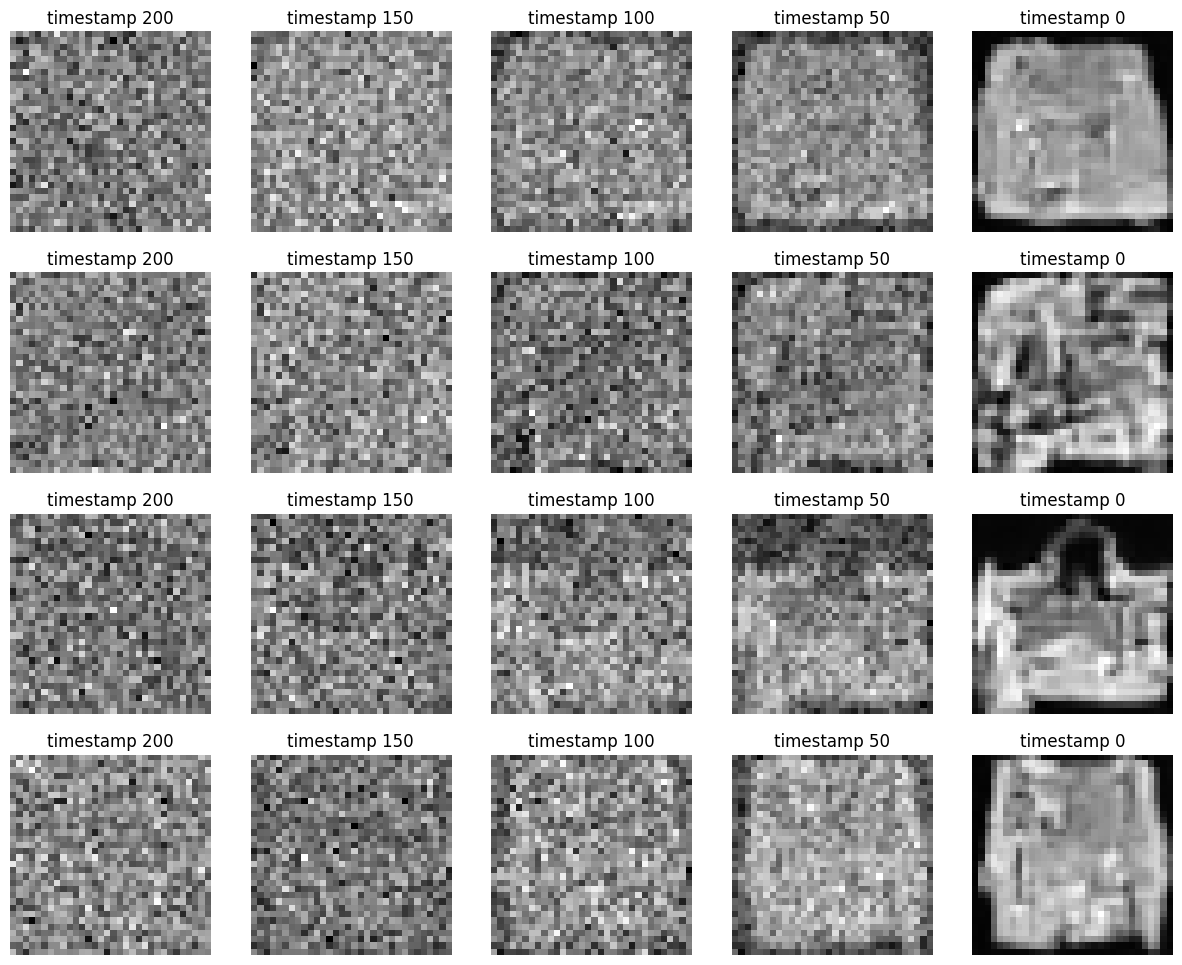



Epoch: 9
step: 0 -- Loss: 0.060
step: 100 -- Loss: 0.068
step: 200 -- Loss: 0.059
step: 300 -- Loss: 0.055
step: 400 -- Loss: 0.057


<Figure size 1500x9000 with 0 Axes>

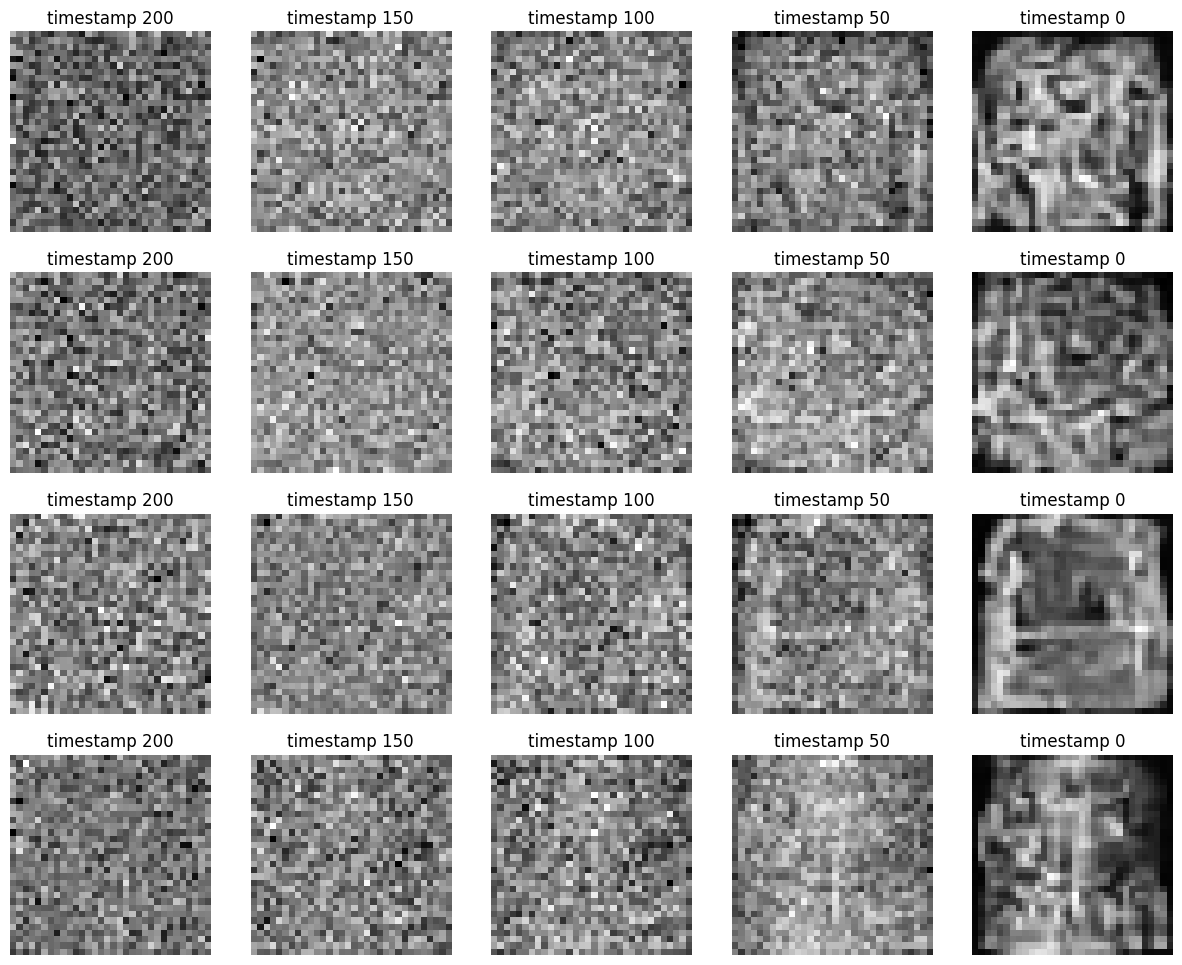

<Figure size 1500x9000 with 0 Axes>

In [18]:
indexes_to_plot = [200, 150, 100, 50, 0]
image_shape = [4, 1, 32, 32]

trainer = Trainer(n_diffusion_timesteps, model, device,
                  indexes_to_plot=indexes_to_plot)

trainer.train(train_loader, n_epochs, image_shape=image_shape)

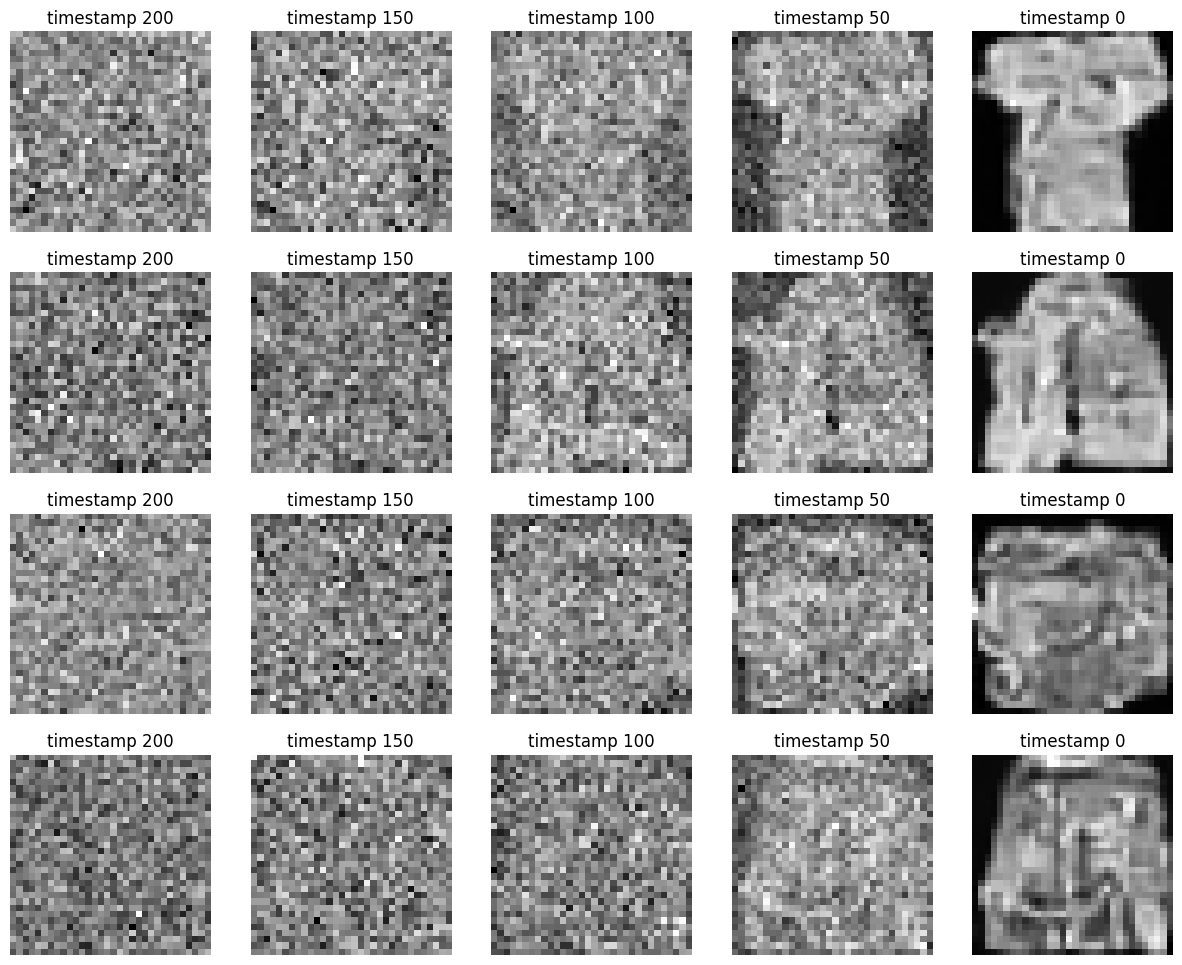

In [19]:
# Sample images

generated_images = trainer.diffusion_reverse_process.generate_images(image_shape)


assert len(generated_images) == (n_diffusion_timesteps + 1) and generated_images[0].shape == torch.Size(image_shape)
plot_torch_images_of_selected_indexes(generated_images, indexes_to_plot, results_path=None, show=True)

# Code related to the theoretical question.


In [24]:
'''
This function is similar to generate_images in ReverseDiffusionProcess class.
However, it does not belong to the class, and it takes diffusion_reverse_process and timestemps_to_sample_on as parameters.
timestemps_to_sample_on is a list of timestamps, along which the generation should follow.
If timestemps_to_sample_on is equal to [T, ..., 0], the output should be equivalent to the output of the generate_images function.
'''
@torch.no_grad()
def generate_images_along_timestemps(diffusion_reverse_process, image_shape, timestemps_to_sample_on, noise=None):
    '''
    :param noise: x_T, If noise == None - start from a random noise, else start from a given noise
    :return: list_of_x_t
    '''

    device = next(diffusion_reverse_process.model.parameters()).device
    # list_of_x_t = ... list of images generated at timestamp t for timestamps in timestemps_to_sample_on
    # YOUR CODE HERE
    T = diffusion_reverse_process.n_diffusion_timesteps       
    timesteps = np.asarray(timestemps_to_sample_on, dtype=int)
    x_t = torch.randn(image_shape, device=device) if noise is None else noise.to(device)
    list_of_x_t = [x_t]                                         
    prev_t = T                                                 

    schedule = timesteps[1:] if timesteps[0] == T else timesteps

    for next_t in schedule:
        for t in range(prev_t - 1, next_t - 1, -1):
            t_tensor = torch.full(
                (x_t.shape[0],), t, device=device, dtype=torch.long
            )
            x_t = diffusion_reverse_process.generate_images_at_previous_timestamp(
                x_t, t_tensor
            )
        list_of_x_t.append(x_t)                                 
        prev_t = next_t

    return list_of_x_t

# utility functions for plotting the images that were generated with skipped timestamps
def return_indexes_to_plot_from_skipped_indexes(timestemps_to_sample_on, indexes_to_plot):
    result = []
    indexes_to_plot_that_exist = []
    for idx in indexes_to_plot:
        where = np.where(timestemps_to_sample_on == idx)[0]
        if len(where) == 0:
            continue
        result.append(where.min())
        indexes_to_plot_that_exist.append(idx)
    return result, indexes_to_plot_that_exist


def plot_images_generate_with_skipped_indexes(generate_images_for_t, timestemps_to_sample_on, indexes_to_plot, description_of_timestamps_skipped):
    generate_images_for_t = generate_images_along_timestemps(trainer.diffusion_reverse_process, image_shape, timestemps_to_sample_on, noise=None)

    skipped_indexes_to_plot, indexes_to_plot_that_exist = return_indexes_to_plot_from_skipped_indexes(timestemps_to_sample_on, indexes_to_plot)
    print(f'Plot timestamps {skipped_indexes_to_plot} for sampling where {description_of_timestamps_skipped} where skipped during generation')
    plot_torch_images_of_selected_indexes(generate_images_for_t, skipped_indexes_to_plot, results_path=None, show=True,
                                         images_in_reversed_order=False, titles=[f'timestamp {t}' for t in indexes_to_plot_that_exist] * image_shape[0])

Plot timestamps [0, 50, 100, 124, 125, 129] for sampling where timestamps in range [5, 75] where skipped during generation


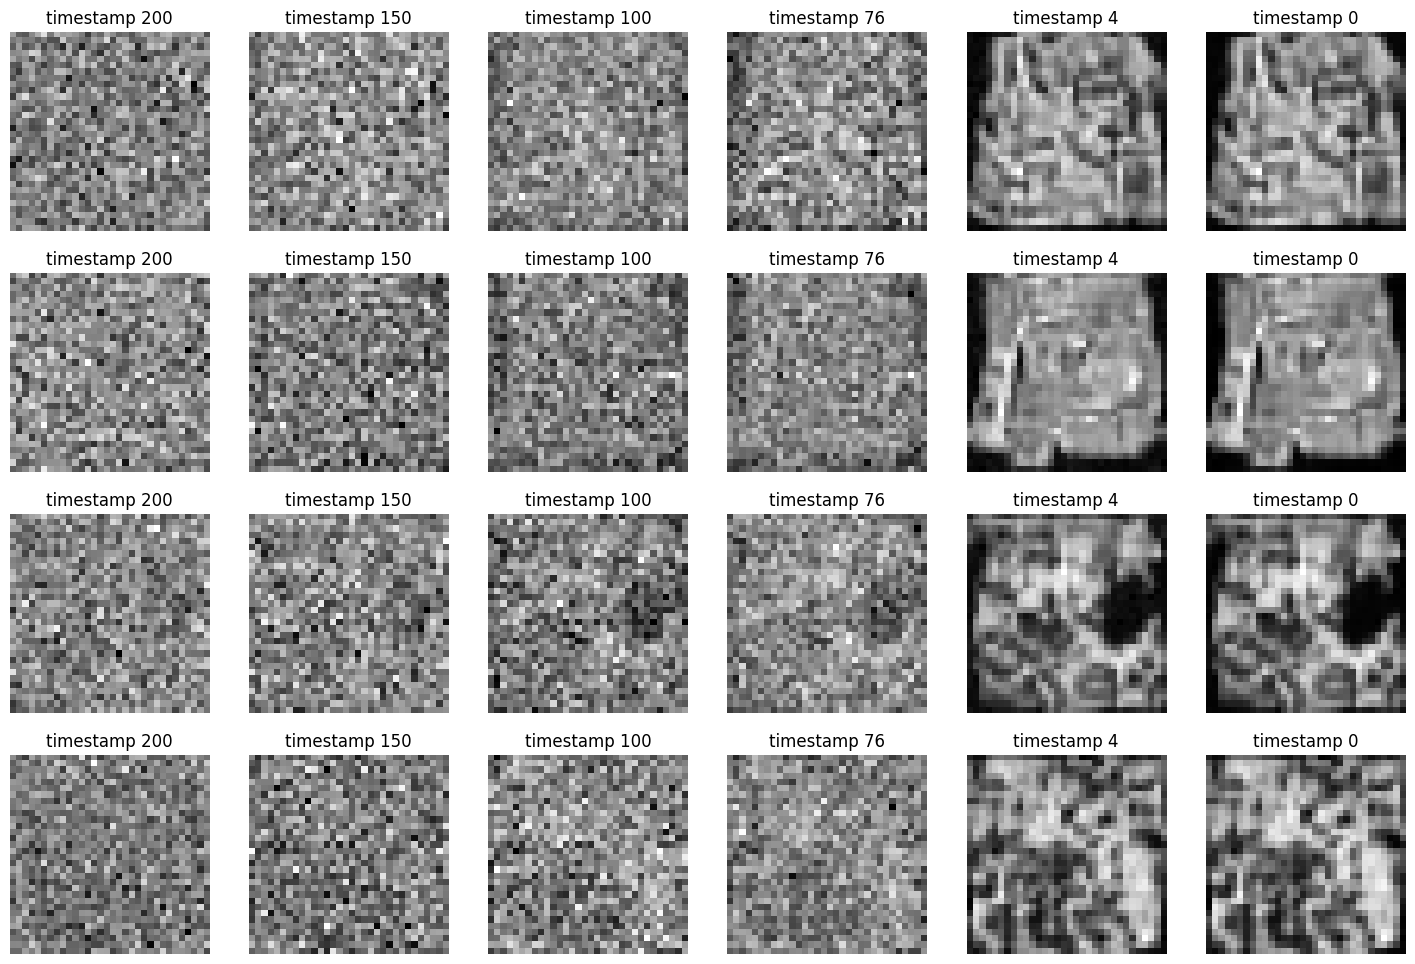

In [25]:
#skipping timestamps in range [5, 75]
description_of_timestamps_skipped = 'timestamps in range [5, 75]'
timestemps_to_sample_on = np.array(list(range(200, 75, -1)) + list(range(4, -1, -1)) )
indexes_to_plot = [200, 150, 100, 76, 4, 0]

generate_images_for_t = generate_images_along_timestemps(trainer.diffusion_reverse_process, image_shape, timestemps_to_sample_on, noise=None)
plot_images_generate_with_skipped_indexes(generate_images_for_t, timestemps_to_sample_on, indexes_to_plot,
                                          description_of_timestamps_skipped)

Plot timestamps [0, 29, 79, 129] for sampling where timestamps in range [130, 200] where skipped during generation


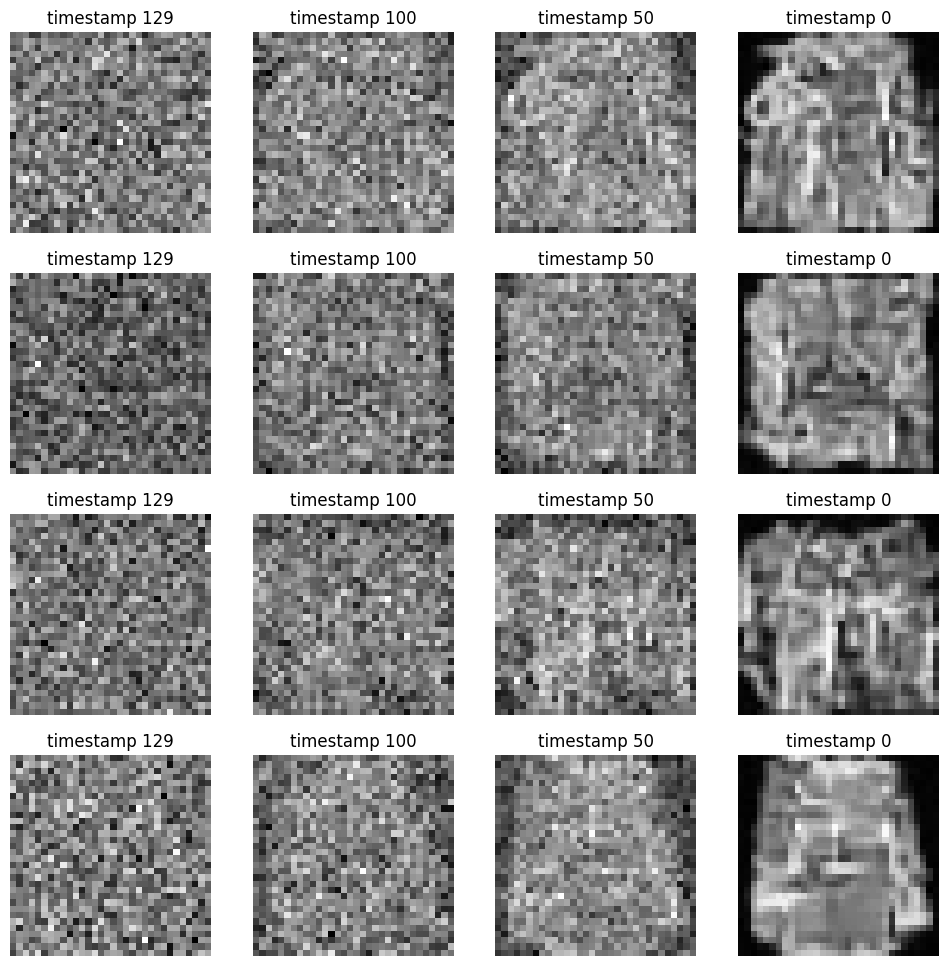

In [26]:
#skipping timestamps in range [130, 200]
description_of_timestamps_skipped = 'timestamps in range [130, 200]'
timestemps_to_sample_on = np.array(list(range(129, -1, -1)) )
indexes_to_plot = [129, 100, 50, 0]

generate_images_for_t = generate_images_along_timestemps(trainer.diffusion_reverse_process, image_shape, timestemps_to_sample_on, noise=None)
plot_images_generate_with_skipped_indexes(generate_images_for_t, timestemps_to_sample_on, indexes_to_plot,
                                          description_of_timestamps_skipped)